/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loaded historical
Loaded ssp126
Loaded ssp245
Loaded ssp585


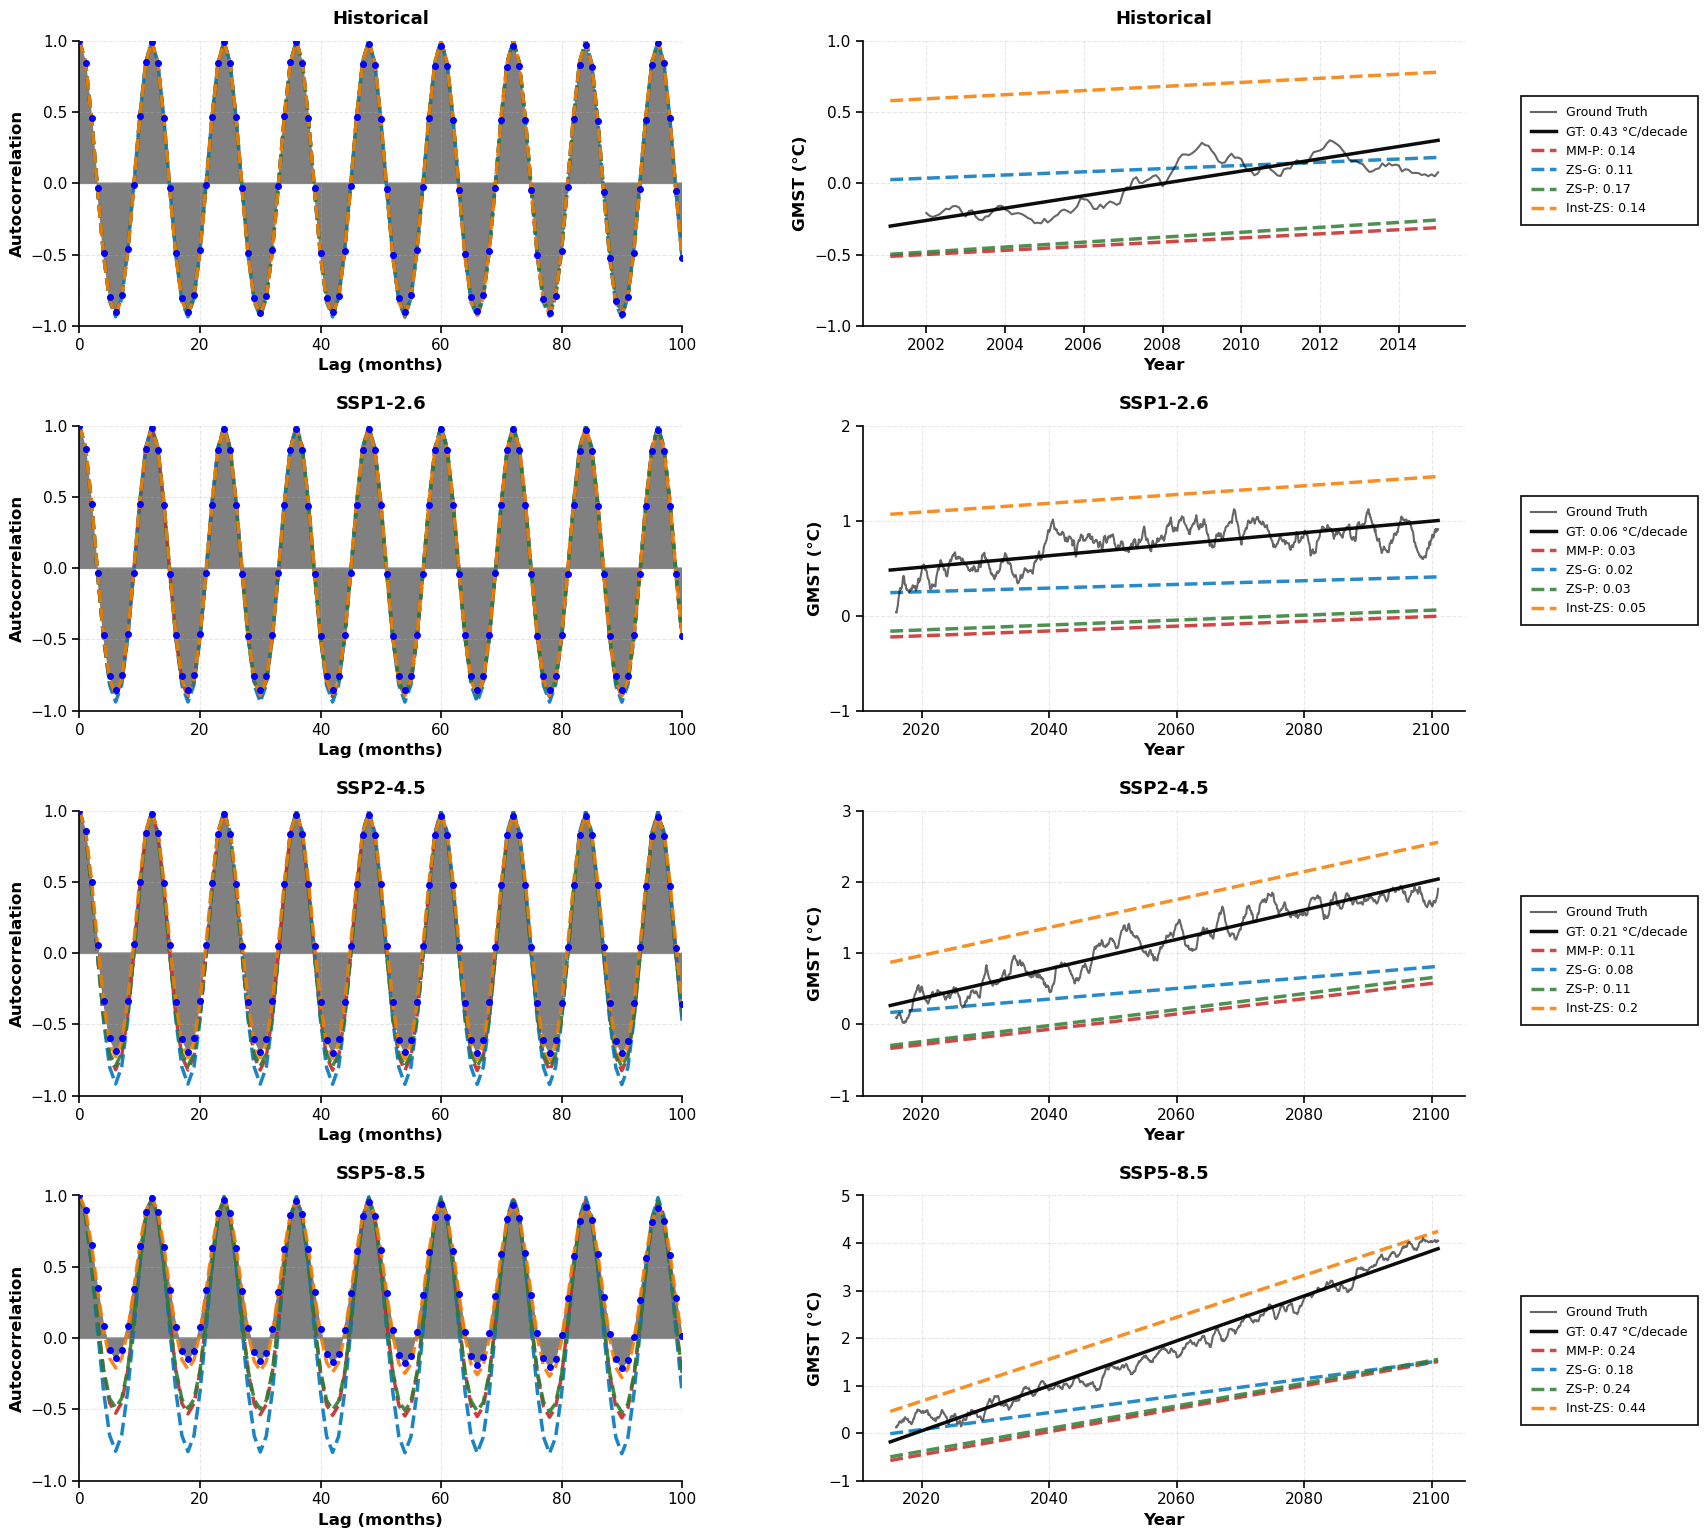

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from scipy import stats

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")  
figures_dir = Path("../Figures")             

scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Only analyze temperature with 4 models
var_name = 'tas'
var_label = 'Temperature'
var_unit = '°C'

normalizations = ['minmax_pixel', 'zscore_global', 'zscore_pixel', 'instance_zscore']

# Normalization labels
norm_labels = {
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Y-axis configuration for temperature trends (scenario-specific)
trend_yaxis_config = {
    'historical': {'lim': (-1.0, 1.0), 'ticks': [-1.0, -0.5, 0.0, 0.5, 1.0]},
    'ssp126': {'lim': (-1, 2), 'ticks': [-1, 0, 1, 2]},
    'ssp245': {'lim': (-1, 3), 'ticks': [-1, 0, 1, 2, 3]},
    'ssp585': {'lim': (-1, 5), 'ticks': [-1, 0, 1, 2, 3, 4, 5]}
}

# Colors: Black for GT, Red, Blue, Green, Orange for 4 models
norm_colors = {
    'minmax_pixel': '#C62828',   # Red
    'zscore_global': '#0277BD',  # Blue
    'zscore_pixel': '#2E7D32',   # Green
    'instance_zscore': '#F57C00' # Orange
}

# ----------------------------
# Functions
# ----------------------------
def calc_global_mean(data):
    """Calculate global mean time series."""
    if isinstance(data, xr.DataArray):
        return data.mean(dim=['lat', 'lon']).values
    else:
        return np.mean(data, axis=(1, 2))

def calculate_autocorrelation(time_series, max_lag=100):
    """Calculate temporal autocorrelation function."""
    n = len(time_series)
    mean = np.mean(time_series)
    var = np.var(time_series)
    
    acf = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        if lag == 0:
            acf[lag] = 1.0
        else:
            c0 = np.sum((time_series[:n-lag] - mean) * (time_series[lag:] - mean))
            acf[lag] = c0 / (var * (n - lag))
    
    lags = np.arange(max_lag + 1)
    return lags, acf

def calculate_trend(time_series, time_coords):
    """Calculate linear trend using least squares regression."""
    # Remove NaN values
    mask = ~np.isnan(time_series)
    x = time_coords[mask]
    y = time_series[mask]
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value

# ----------------------------
# Load data
# ----------------------------
all_data = {}
for scenario in scenarios:
    results_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds = xr.open_dataset(results_file)
    all_data[scenario] = ds
    print(f"Loaded {scenario}")

# Calculate historical test period climatology for anomaly calculation
hist_ds = all_data['historical']
hist_gt = hist_ds['groundtruth'].values
hist_gt_mean = calc_global_mean(hist_gt)
hist_climatology = np.mean(hist_gt_mean)

# ----------------------------
# Create figure
# ----------------------------
# Set plotting style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10

# Create figure with extra space on the right for legend
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3, 
                      left=0.08, right=0.85, top=0.95, bottom=0.05)

# Plot each scenario (row)
for row_idx, scenario in enumerate(scenarios):
    ds = all_data[scenario]
    gt_data = ds['groundtruth'].values
    time = ds.time
    
    # Convert time to decimal years for trend analysis
    years = time.dt.year.values + time.dt.month.values / 12.0
    
    # Get ground truth global mean time series
    gt_mean = calc_global_mean(gt_data)
    
    # Convert to anomaly relative to historical climatology
    gt_mean_anomaly = gt_mean - hist_climatology
    
    # ========== Left column: Autocorrelation ==========
    ax_acf = fig.add_subplot(gs[row_idx, 0])
    
    # Calculate ground truth autocorrelation (max_lag=100)
    lags, gt_acf = calculate_autocorrelation(gt_mean, max_lag=100)
    
    # Plot ground truth ACF as SOLID GREY SHADED AREA (no transparency)
    ax_acf.fill_between(lags, 0, gt_acf, where=(gt_acf >= 0),
                        color='grey', alpha=1.0, interpolate=True)
    ax_acf.fill_between(lags, 0, gt_acf, where=(gt_acf < 0),
                        color='grey', alpha=1.0, interpolate=True)
    
    # Add BLUE DOTS on ground truth
    ax_acf.plot(lags, gt_acf, 'o', color='blue', markersize=4, zorder=20)
    
    # Plot predictions ACF as colored dashed lines
    for norm in normalizations:
        pred_key = f'pred_{norm}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Calculate autocorrelation
            _, pred_acf = calculate_autocorrelation(pred_mean, max_lag=100)
            
            ax_acf.plot(lags, pred_acf, 
                       color=norm_colors[norm],
                       linewidth=2.5, alpha=0.9,
                       linestyle='--',
                       label=norm_labels[norm])
    
    # Format ACF plot
    ax_acf.set_xlabel('Lag (months)', fontsize=12, fontweight='bold')
    ax_acf.set_ylabel('Autocorrelation', fontsize=12, fontweight='bold')
    ax_acf.set_title(f'{scenario_labels[scenario]}', 
                    fontsize=13, fontweight='bold', color='black',
                    pad=12, loc='center')  # Changed to center
    ax_acf.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Fixed y-axis limits and ticks
    ax_acf.set_ylim(-1.0, 1.0)
    ax_acf.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
    
    ax_acf.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax_acf.set_xlim(0, 100)
    
    ax_acf.tick_params(labelsize=11, length=5, width=1.2)
    ax_acf.spines['top'].set_visible(False)
    ax_acf.spines['right'].set_visible(False)
    ax_acf.spines['bottom'].set_linewidth(1.2)
    ax_acf.spines['left'].set_linewidth(1.2)
    
    # ========== Right column: Trend (ANOMALY) ==========
    ax_trend = fig.add_subplot(gs[row_idx, 1])
    
    # Calculate ground truth trend on anomaly
    gt_slope, gt_intercept, gt_r, gt_p = calculate_trend(gt_mean_anomaly, years)
    
    # Calculate 12-month rolling mean for smoother visualization
    window = 12
    if len(gt_mean_anomaly) >= window:
        gt_anomaly_smooth = np.convolve(gt_mean_anomaly, np.ones(window)/window, mode='valid')
        years_smooth = years[window-1:]
    else:
        gt_anomaly_smooth = gt_mean_anomaly
        years_smooth = years
    
    # Plot ground truth as BLACK line
    line_gt_smooth, = ax_trend.plot(years_smooth, gt_anomaly_smooth, color='black', 
                                     linewidth=1.5, alpha=0.6, zorder=18)
    
    # Plot ground truth trend line
    gt_trend_line = gt_slope * years + gt_intercept
    trend_value = round(gt_slope * 10, 2)
    line_gt_trend, = ax_trend.plot(years, gt_trend_line, 'k-', linewidth=2.5, 
                                    alpha=0.95, zorder=19)
    
    # Store handles and labels for combined legend
    legend_handles = [line_gt_smooth, line_gt_trend]
    legend_labels = ['Ground Truth', f'GT: {trend_value} {var_unit}/decade']
    
    # Plot predictions with trend lines (ANOMALY)
    for norm in normalizations:
        pred_key = f'pred_{norm}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Convert to anomaly
            pred_mean_anomaly = pred_mean - hist_climatology
            
            # Calculate trend
            pred_slope, pred_intercept, pred_r, pred_p = calculate_trend(pred_mean_anomaly, years)
            
            # Plot trend line
            pred_trend_line = pred_slope * years + pred_intercept
            trend_value = round(pred_slope * 10, 2)
            line_pred, = ax_trend.plot(years, pred_trend_line, 
                                       color=norm_colors[norm],
                                       linewidth=2.5, alpha=0.85,
                                       linestyle='--')
            
            legend_handles.append(line_pred)
            legend_labels.append(f'{norm_labels[norm]}: {trend_value}')
    
    # Format trend plot
    ax_trend.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax_trend.set_ylabel(f'GMST ({var_unit})', fontsize=12, fontweight='bold')
    ax_trend.set_title(f'{scenario_labels[scenario]}', 
                      fontsize=13, fontweight='bold', color='black',
                      pad=12, loc='center')  # Changed to center
    ax_trend.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Scenario-specific y-axis limits and ticks
    ax_trend.set_ylim(trend_yaxis_config[scenario]['lim'])
    ax_trend.set_yticks(trend_yaxis_config[scenario]['ticks'])
    
    ax_trend.tick_params(labelsize=11, length=5, width=1.2)
    ax_trend.spines['top'].set_visible(False)
    ax_trend.spines['right'].set_visible(False)
    ax_trend.spines['bottom'].set_linewidth(1.2)
    ax_trend.spines['left'].set_linewidth(1.2)
    
    # ========== Combined legend for this row (far right) ==========
    legend = fig.legend(handles=legend_handles, labels=legend_labels,
                       loc='center', bbox_to_anchor=(0.93, 0.875 - row_idx * 0.25),
                       fontsize=9, frameon=True, fancybox=False,
                       edgecolor='black', framealpha=0.98,
                       borderpad=0.8, labelspacing=0.5)
    legend.get_frame().set_linewidth(1.2)
    
    # Save figure
    output_file = figures_dir / "06_temporal_dynamics_tas.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')

Loaded historical
Loaded ssp126
Loaded ssp245
Loaded ssp585


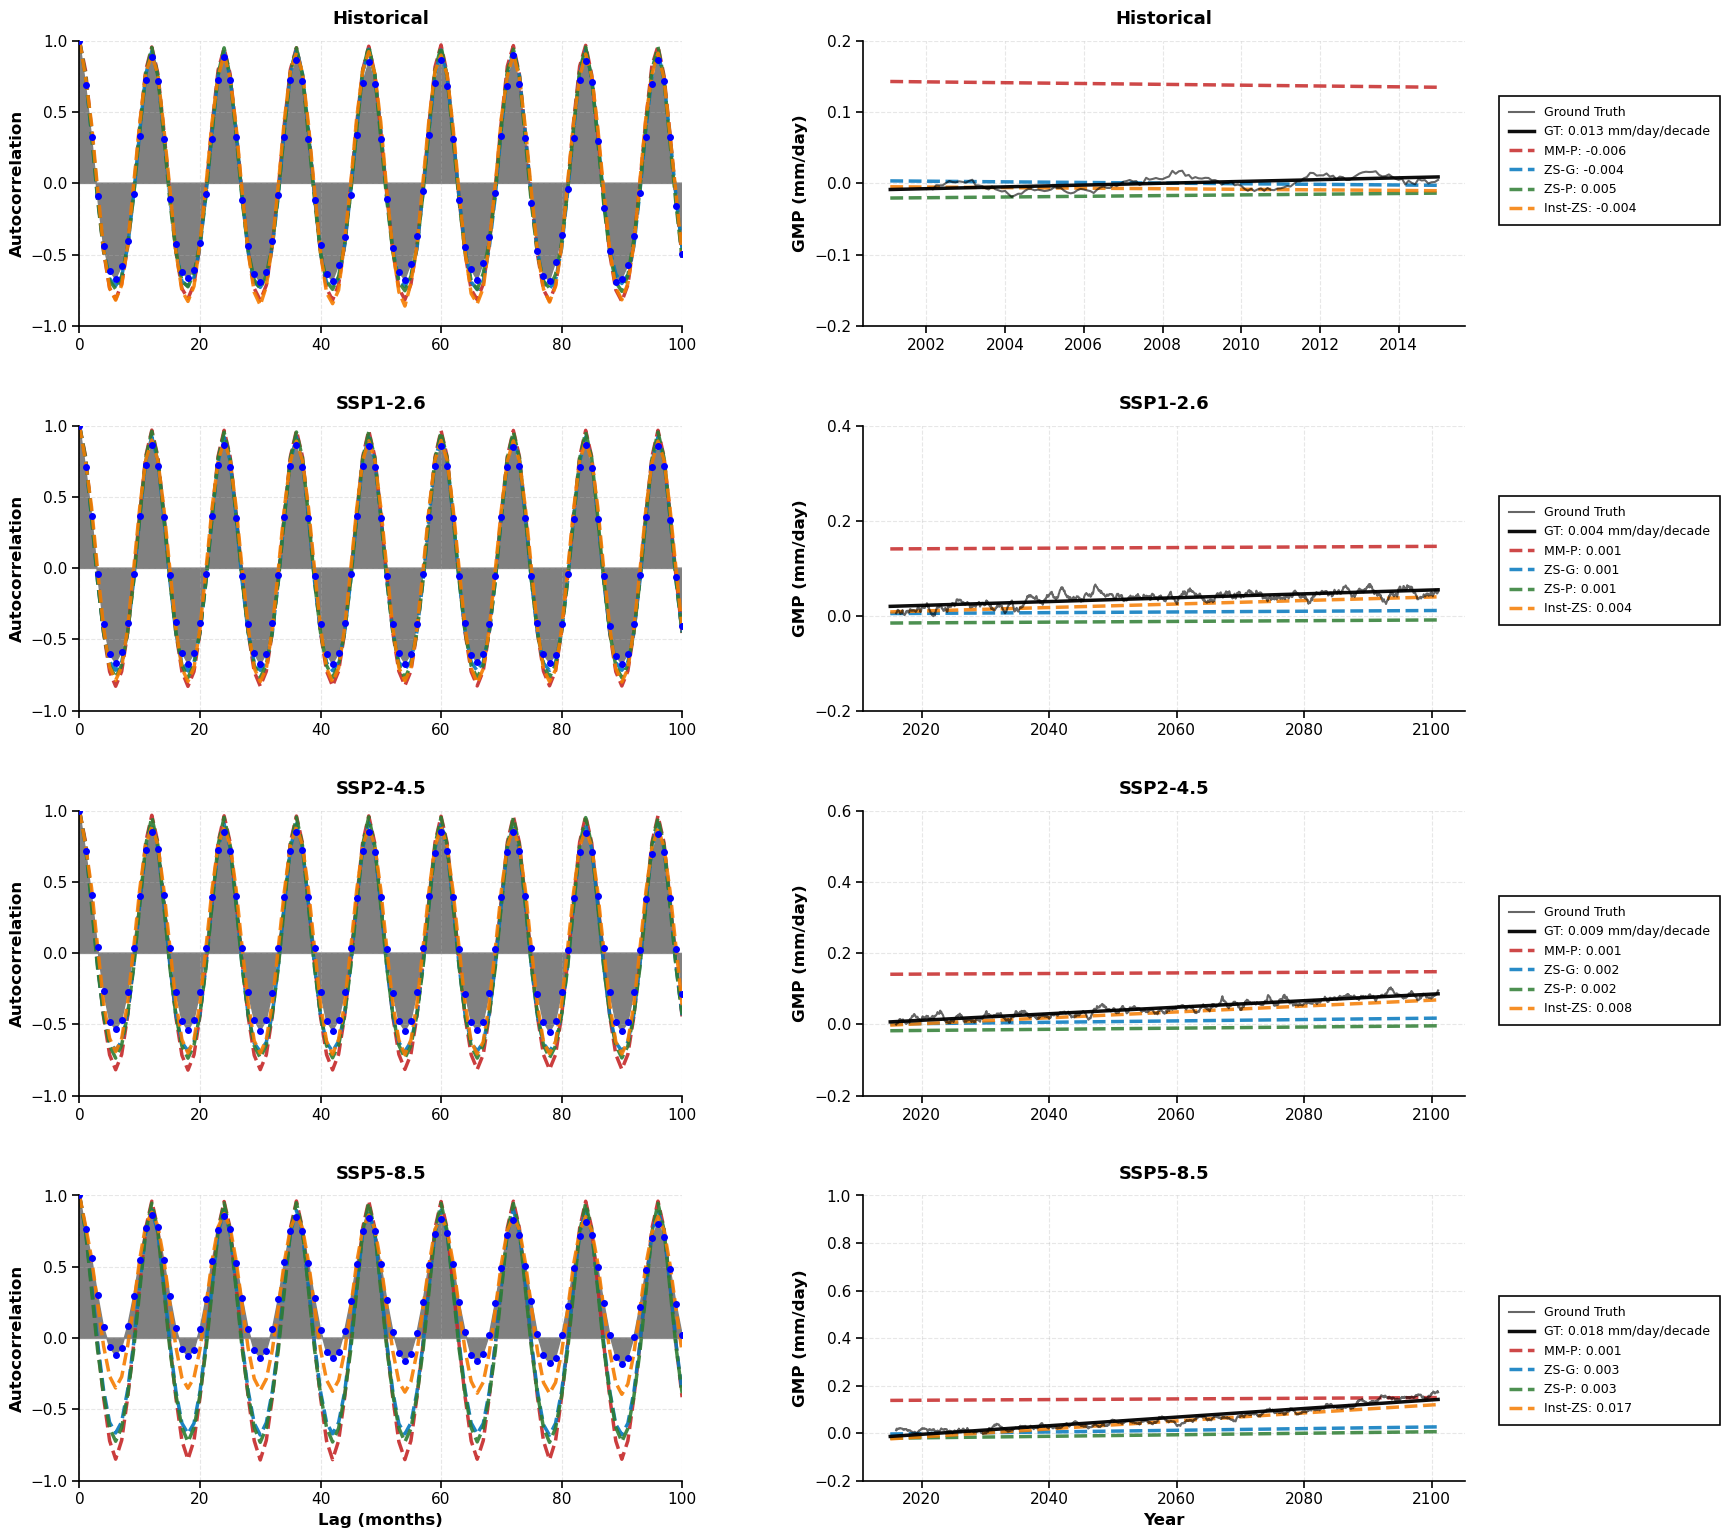

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from scipy import stats

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")  
figures_dir = Path("../Figures") 

scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Only analyze PRECIPITATION with 4 models
var_name = 'pr'
var_label = 'Precipitation'
var_unit = 'mm/day'

normalizations = ['minmax_pixel', 'zscore_global', 'zscore_pixel', 'instance_zscore']

# Normalization labels
norm_labels = {
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Y-axis configuration for precipitation trends (scenario-specific)
# Adjusted for precipitation scale
trend_yaxis_config = {
    'historical': {'lim': (-0.2, 0.2), 'ticks': [-0.2, -0.1, 0.0, 0.1, 0.2]},
    'ssp126': {'lim': (-0.2, 0.4), 'ticks': [-0.2, 0.0, 0.2, 0.4]},
    'ssp245': {'lim': (-0.2, 0.6), 'ticks': [-0.2, 0.0, 0.2, 0.4, 0.6]},
    'ssp585': {'lim': (-0.2, 1.0), 'ticks': [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}
}

# Colors: Black for GT, Red, Blue, Green, Orange for 4 models
norm_colors = {
    'minmax_pixel': '#C62828',   # Red
    'zscore_global': '#0277BD',  # Blue
    'zscore_pixel': '#2E7D32',   # Green
    'instance_zscore': '#F57C00' # Orange
}

# ----------------------------
# Functions
# ----------------------------
def calc_global_mean(data):
    """Calculate global mean time series."""
    if isinstance(data, xr.DataArray):
        return data.mean(dim=['lat', 'lon']).values
    else:
        return np.mean(data, axis=(1, 2))

def calculate_autocorrelation(time_series, max_lag=100):
    """Calculate temporal autocorrelation function."""
    n = len(time_series)
    mean = np.mean(time_series)
    var = np.var(time_series)
    
    acf = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        if lag == 0:
            acf[lag] = 1.0
        else:
            c0 = np.sum((time_series[:n-lag] - mean) * (time_series[lag:] - mean))
            acf[lag] = c0 / (var * (n - lag))
    
    lags = np.arange(max_lag + 1)
    return lags, acf

def calculate_trend(time_series, time_coords):
    """Calculate linear trend using least squares regression."""
    # Remove NaN values
    mask = ~np.isnan(time_series)
    x = time_coords[mask]
    y = time_series[mask]
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value

# ----------------------------
# Load data
# ----------------------------
all_data = {}
for scenario in scenarios:
    results_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds = xr.open_dataset(results_file)
    all_data[scenario] = ds
    print(f"Loaded {scenario}")

# Calculate historical test period climatology for anomaly calculation
hist_ds = all_data['historical']
hist_gt = hist_ds['groundtruth'].values
hist_gt_mean = calc_global_mean(hist_gt)
hist_climatology = np.mean(hist_gt_mean)

# ----------------------------
# Create figure
# ----------------------------
# Set plotting style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10

# Create figure with extra space on the right for legend
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3, 
                      left=0.08, right=0.85, top=0.95, bottom=0.05)

# Plot each scenario (row)
for row_idx, scenario in enumerate(scenarios):
    ds = all_data[scenario]
    gt_data = ds['groundtruth'].values
    time = ds.time
    
    # Convert time to decimal years for trend analysis
    years = time.dt.year.values + time.dt.month.values / 12.0
    
    # Get ground truth global mean time series
    gt_mean = calc_global_mean(gt_data)
    
    # Convert to anomaly relative to historical climatology
    gt_mean_anomaly = gt_mean - hist_climatology
    
    # ========== Left column: Autocorrelation ==========
    ax_acf = fig.add_subplot(gs[row_idx, 0])
    
    # Calculate ground truth autocorrelation (max_lag=100)
    lags, gt_acf = calculate_autocorrelation(gt_mean, max_lag=100)
    
    # Plot ground truth ACF as SOLID GREY SHADED AREA (no transparency)
    ax_acf.fill_between(lags, 0, gt_acf, where=(gt_acf >= 0),
                        color='grey', alpha=1.0, interpolate=True)
    ax_acf.fill_between(lags, 0, gt_acf, where=(gt_acf < 0),
                        color='grey', alpha=1.0, interpolate=True)
    
    # Add BLUE DOTS on ground truth
    ax_acf.plot(lags, gt_acf, 'o', color='blue', markersize=4, zorder=20)
    
    # Plot predictions ACF as colored dashed lines
    for norm in normalizations:
        pred_key = f'pred_{norm}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Calculate autocorrelation
            _, pred_acf = calculate_autocorrelation(pred_mean, max_lag=100)
            
            ax_acf.plot(lags, pred_acf, 
                       color=norm_colors[norm],
                       linewidth=2.5, alpha=0.9,
                       linestyle='--',
                       label=norm_labels[norm])
    
    # Format ACF plot
    # X-axis label only on bottom row
    if row_idx == 3:
        ax_acf.set_xlabel('Lag (months)', fontsize=12, fontweight='bold')
    
    ax_acf.set_ylabel('Autocorrelation', fontsize=12, fontweight='bold')
    ax_acf.set_title(f'{scenario_labels[scenario]}', 
                    fontsize=13, fontweight='bold', color='black',
                    pad=12, loc='center')
    ax_acf.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Fixed y-axis limits and ticks
    ax_acf.set_ylim(-1.0, 1.0)
    ax_acf.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
    
    ax_acf.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax_acf.set_xlim(0, 100)
    
    ax_acf.tick_params(labelsize=11, length=5, width=1.2)
    ax_acf.spines['top'].set_visible(False)
    ax_acf.spines['right'].set_visible(False)
    ax_acf.spines['bottom'].set_linewidth(1.2)
    ax_acf.spines['left'].set_linewidth(1.2)
    
    # ========== Right column: Trend (ANOMALY) ==========
    ax_trend = fig.add_subplot(gs[row_idx, 1])
    
    # Calculate ground truth trend on anomaly
    gt_slope, gt_intercept, gt_r, gt_p = calculate_trend(gt_mean_anomaly, years)
    
    # Calculate 12-month rolling mean for smoother visualization
    window = 12
    if len(gt_mean_anomaly) >= window:
        gt_anomaly_smooth = np.convolve(gt_mean_anomaly, np.ones(window)/window, mode='valid')
        years_smooth = years[window-1:]
    else:
        gt_anomaly_smooth = gt_mean_anomaly
        years_smooth = years
    
    # Plot ground truth as BLACK line
    line_gt_smooth, = ax_trend.plot(years_smooth, gt_anomaly_smooth, color='black', 
                                     linewidth=1.5, alpha=0.6, zorder=18)
    
    # Plot ground truth trend line
    gt_trend_line = gt_slope * years + gt_intercept
    trend_value = round(gt_slope * 10, 3)  # 3 decimals for precipitation
    line_gt_trend, = ax_trend.plot(years, gt_trend_line, 'k-', linewidth=2.5, 
                                    alpha=0.95, zorder=19)
    
    # Store handles and labels for combined legend
    legend_handles = [line_gt_smooth, line_gt_trend]
    legend_labels = ['Ground Truth', f'GT: {trend_value} {var_unit}/decade']
    
    # Plot predictions with trend lines (ANOMALY)
    for norm in normalizations:
        pred_key = f'pred_{norm}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Convert to anomaly
            pred_mean_anomaly = pred_mean - hist_climatology
            
            # Calculate trend
            pred_slope, pred_intercept, pred_r, pred_p = calculate_trend(pred_mean_anomaly, years)
            
            # Plot trend line
            pred_trend_line = pred_slope * years + pred_intercept
            trend_value = round(pred_slope * 10, 3)  # 3 decimals for precipitation
            line_pred, = ax_trend.plot(years, pred_trend_line, 
                                       color=norm_colors[norm],
                                       linewidth=2.5, alpha=0.85,
                                       linestyle='--')
            
            legend_handles.append(line_pred)
            legend_labels.append(f'{norm_labels[norm]}: {trend_value}')
    
    # Format trend plot
    # X-axis label only on bottom row
    if row_idx == 3:
        ax_trend.set_xlabel('Year', fontsize=12, fontweight='bold')
    
    ax_trend.set_ylabel(f'GMP ({var_unit})', fontsize=12, fontweight='bold')  # GMP = Global Mean Precipitation
    ax_trend.set_title(f'{scenario_labels[scenario]}', 
                      fontsize=13, fontweight='bold', color='black',
                      pad=12, loc='center')
    ax_trend.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Scenario-specific y-axis limits and ticks
    ax_trend.set_ylim(trend_yaxis_config[scenario]['lim'])
    ax_trend.set_yticks(trend_yaxis_config[scenario]['ticks'])
    
    ax_trend.tick_params(labelsize=11, length=5, width=1.2)
    ax_trend.spines['top'].set_visible(False)
    ax_trend.spines['right'].set_visible(False)
    ax_trend.spines['bottom'].set_linewidth(1.2)
    ax_trend.spines['left'].set_linewidth(1.2)
    
    # ========== Combined legend for this row (far right) ==========
    legend = fig.legend(handles=legend_handles, labels=legend_labels,
                       loc='center', bbox_to_anchor=(0.93, 0.875 - row_idx * 0.25),
                       fontsize=9, frameon=True, fancybox=False,
                       edgecolor='black', framealpha=0.98,
                       borderpad=0.8, labelspacing=0.5)
    legend.get_frame().set_linewidth(1.2)
    
    # Save figure
    output_file = figures_dir / "07_temporal_dynamics_pr.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')